## Содержание

1.
2.
3.

## Описание

Практика следующих тем:
- Парсинг
- Визуализация 
- Географическая визуализация

Предметная область данных:
- Фигурное катание

## Справка по предметной области

Современное оценивание соревнований по фигурному катанию представляет собой целый набор правил и формул для расчета итогового результата.
Каждый элемент оценивается судейской бригодой и техническими специалистами и приносит спортсмену определенную базовую стоимость (BV) и надбавки за качество (GOE).
Также отдельно оцениваются художественные "компоненты", тоже по определенным правилам. Спортсмен выступает два раза с разным набором элементов - с короткой и произвольной программой. Результат суммируется.
Такая система используется с 2004 года и называется "новой системой оценивания" или "новой системой судейства" (взамен "старой" - основаной на оценках типа "6.0")

Новая система судейства была нацелена на справедливость и снижение фактора субъективности в оценивании. При современном подходе итоговые протоколы оценивания позволяют не только выявить победителя, но и оценить вклад в его результат каждого отдельного элемента. Таким образом протоколы содержат достаточное количество данных, по которым можно собрать определенную статистику и провести некоторый анализ

Пример протокола судейства для короткой программы Ирины Слуцкой на чемпионате мира 2005 года

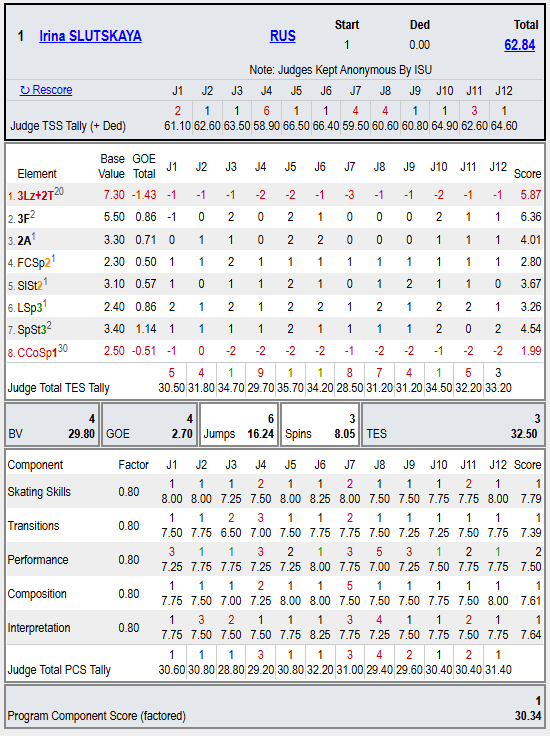


## Импорты

In [ ]:
# # pip install beautifulsoup4 
# # pip install lxml
# # pip install requests
# !pip install tqdm
# pip install openpyxl --upgrade

In [15]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
from tqdm import tqdm

In [83]:
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None


## Получение данных

В качестве источника взят сайт с официальными результатами соревнований по фигруному катанию в новой системе оценивания

Общий вид страницы выглядит следующим образом:

https://skatingscores.com/2425/wc/sr/women/i/short/usa/alysa_liu/

https://skatingscores.com/сезон/чемпионат/возрастная категория/дисциплина/i/программа/страна/участник/

Соберем информацию для чемпионатов мира за все года с новой системой оценивания в взрослом женском одиночном катании. Для этого нужно циклом пройтись по всем страницам и собрать нужные данные



In [ ]:
## Пример ссылки выглядит следующим образом: 'https://skatingscores.com/2425/wc/sr/women/i/short/'

## Нам нужно будет пройтись по всем годам
### Года указаны в ссылке как сезоны, то есть по парам с сезона 0405 до сезона 2425

## Рассматриваем только женщин, но нам нужны будут короткие и произвольные программы
# Таким образом нам нужен цикл для сбора ссылок

df_final = pd.DataFrame()
for i in tqdm(range(116,125), ncols=80, ascii=True, desc='Total'):
    season = str(i)[-2:]+str(i+1)[-2:]
    # print(season)
    for program in tqdm(['long','short']):
        url = 'https://skatingscores.com/'+season+'/wc/sr/women/i/'+program+'/'
        # print(url)
        time.sleep(3)
        page = requests.get(url)
        soup = BeautifulSoup(page.text, "html.parser")
        # print(page)
        ## Каждая страницы содержит список участниц со отдельными ссылками на результаты каждой
        # Получаем все ссылки
        df_total_score = pd.DataFrame()
        for link in tqdm(soup.find_all('a')):
            link_ = link.get('href')
            # print(link_)
            time.sleep(3)
    #         # Фильтруем ссылки участниц от ссылок на судей и прочих возможных по шаблону
            if '/wc/sr/women/i/' in link_ and 'panel' not in link_ and 're' in link_:
                # print(link_)
                try:
                    print(link_)
                    country_girl = link_.split('/')[-3]
                    girl = link_.split('/')[-2]
                    # print(girl)
                    # print(country_girl)
                    if 'long' not in girl and 'short' not in girl and country_girl != 'i':
                        # Собираем ссылку
                        girl_link = url+country_girl+'/'+girl+'/'
                        # print(girl_link)
                        page_girl = requests.get(girl_link)
                        # print(page_girl.status_code)    
                        soup_girl = BeautifulSoup(page_girl.text, "html.parser")
                        time.sleep(3)
                        # print(page_girl)
                # except:
    #                 # break
                        # Получаем все таблицы со страницы
                        ### Здесь много таблиц, так как в каждой представлена своя информация по различным оценкам иих состовляющим
                        tables = soup_girl.find_all('table')  
                        # Берем нужные нам параметры из каждой таблицы
                        # Здесь самая общая информация без подробных оценок за элементы
                        df_1 = pd.read_html(str(tables[0]))[0].tail(1).rename(columns={1: 'Name', 2: 'Country', 4: 'Dedaction', 5: 'Total'})
                        df_2 = pd.read_html(str(tables[1]))[0]    
                        df_2 = df_2.drop(columns=[i for i  in range(6)]+[15]).rename(columns=df_2.iloc[0]).tail(1)
                        df_3 = pd.read_html(str(tables[3]))[0][[0,1]].T
                        df_3 = df_3.rename(columns=df_3.iloc[0]).tail(1)
                        df_4 = pd.read_html(str(tables[10]))[0]
                        df_4 = df_4[[15]].rename(columns={15: 'Component'}).reset_index()
                        df_4['index'] = 1
                        df_4 = df_4.set_index(['index'])
                        df_first = df_1.join(df_2)
                        df_second = df_3.join(df_4)
                        df_all = df_first.join(df_second)
                        df_all = df_all.drop([0], axis=1)
                        df_total_score = pd.concat([df_total_score,df_all])  
                except:
                    print(f'Некорректная ссылка: {link_}')
                    pass
        # # Убираем лишние цифры
        df_total_score = df_total_score.replace(to_replace ='\d+\s', value = '', regex = True)
        df_total_score['Name'] = df_total_score['Name'].replace(to_replace ='\d+', value = '', regex = True)
        # Убираем лишние буквы
        df_total_score = df_total_score.replace(to_replace ='SB', value = '', regex = True) 
        df_total_score = df_total_score.replace(to_replace ='PB', value = '', regex = True) 
        # df_total_score = df_total_score[['Name','Country','Dedaction','Total','ISR 🇮🇱','SVK 🇸🇰','CZE 🇨🇿','FRA 🇫🇷','NOR 🇳🇴','SUI 🇨🇭','JPN 🇯🇵','ITA 🇮🇹','ROU 🇷🇴','BV','GOE','Jumps','Spins','TES','Component']]
        df_total_score['season'] = season
        df_total_score['program'] = program
        # print(df_total_score)
        # break
        df_final = pd.concat([df_total_score,df_final]) 
        df_final = df_final.drop(columns=[3], axis=1) 
## у нас приепилось много лишних столбов, их легко отфильтровать по наличию чисел
for i in range(10):
    df_final = df_final.drop([col for col in df_final.columns if str(i) in col], axis=1)
df_final.to_excel('final_df.xlsx')

# эти данные пока не рассматриваем, оставляем только общии баллы и баллы по странам
df_final = df_final.drop(['Dedaction','BV','GOE','Jumps','Spins','TES','Component'], axis=1)

Total:   0%|                                             | 0/21 [00:00<?, ?it/s]

## Обработка

In [188]:
df_final = pd.read_excel('20_25.xlsx')
df_final = df_final.drop(columns=[3], axis=1)
df_final = df_final.drop([col for col in df_final.columns if str(i) in col], axis=1)

In [189]:
# мы получили список колонок с судьми различных стран
# набор стран меняется в зависимости от сезона

print(df_final.columns)
## это основная информация о программе
info_columns = ['Name','Country','Total','season','program']
set1 = set(df_final.columns)
set2 = set(info_columns)
set3 = set1 - set2
country_columns = list(set3)
## нужно убрать лишнии буквы еще из названий столбов
df_final = df_final.rename({col:col[:3] for col in country_columns}, axis='columns')
country_columns_new = [col[:3] for col in country_columns]
## для удобства
df_final['season+program']= df_final['season'].astype(str) + df_final['program']


Index(['Unnamed: 0', 'Name', 'Country', 'Dedaction', 'Total', 'ISR 🇮🇱',
       'SVK 🇸🇰', 'CZE 🇨🇿', 'FRA 🇫🇷', 'NOR 🇳🇴',
       ...
       'BVPB 12 58.01', 'BVPB 21 50.49', 'BVPB 15 54.28', 'BVPB 6 60.25',
       'BVSB 20 50.63', 'BVPB 14 54.36', 'BVSB 16 53.90', 'BV 22 46.76',
       'BVSB 23 42.97', 'BV 24 39.72'],
      dtype='object', length=320)


In [191]:
dict_prog = {}
for c in country_columns_new:    
    p = df_final[['season+program',c]].dropna()['season+program'].unique()
    dict_prog[c] = p
# dict_prog


In [ ]:
## Получим спиcок стран-судей для каждого сезона и программы
## для этого мы просто выбираем список столбов не пустых для конкретной программы
dict_prog = {}

for s in df_final['season'].unique():
    for p in df_final['program'].unique():
        c = df_final.loc[(df_final['season']==s)&(df_final['program']==p)].dropna(axis='columns',how='all', inplace=False).drop(info_columns, axis=1).columns
        key = str(s)+"_"+str(p) 
        dict_prog[key] = c
        # print(s,p,c)

## Для подсчета удобнее представить в формате типа матрицы



In [182]:

dict_prog

{'RUS': array(['2021short', '2021long'], dtype=object),
 'SUI': array(['2425short', '2425long', '2223long'], dtype=object),
 'ITA': array(['2425short', '2425long', '2324short', '2324long', '2122short',
        '2122long', '2021short'], dtype=object),
 'POL': array(['2425long', '2324short', '2324long', '2223short'], dtype=object),
 'BUL': array(['2324short', '2223short', '2223long', '2122long'], dtype=object),
 'KOR': array(['2324long', '2223short', '2122short', '2122long'], dtype=object),
 'FIN': array(['2324long', '2122short'], dtype=object),
 'LAT': array(['2324short', '2324long'], dtype=object),
 'CZE': array(['2425short', '2425long', '2021short', '2021long'], dtype=object),
 'DEN': array(['2021long'], dtype=object),
 'SVK': array(['2425short', '2324short', '2021short', '2021long'], dtype=object),
 'JPN': array(['2425short', '2425long', '2324short', '2223long', '2122short',
        '2122long'], dtype=object),
 'AUT': array(['2223short', '2122long'], dtype=object),
 'TPE': array(['22

In [181]:
pd.DataFrame.from_dict(dict_prog)

ValueError: All arrays must be of the same length

In [184]:
dict_progs = {}
for s in df_final['season'].unique():
    for p in df_final['program'].unique():
        for c in df_final.loc[(df_final['season']==s)&(df_final['program']==p)].dropna(axis='columns',how='all', inplace=False).drop(info_columns, axis=1).columns:
            dict_progs[c] = str(s)+"_"+str(p)
dict_progs
            

{'ISR': '2425_short',
 'SVK': '2021_long',
 'CZE': '2021_long',
 'FRA': '2021_short',
 'NOR': '2324_short',
 'SUI': '2223_long',
 'JPN': '2122_long',
 'ITA': '2021_short',
 'ROU': '2324_long',
 'sea': '2021_long',
 'season+program': '2021_long',
 'SWE': '2021_long',
 'BEL': '2021_short',
 'USA': '2021_long',
 'POL': '2223_short',
 'BUL': '2122_long',
 'HUN': '2122_long',
 'LAT': '2324_long',
 'CAN': '2122_long',
 'FIN': '2122_short',
 'KOR': '2122_long',
 'AUT': '2122_long',
 'TPE': '2122_long',
 'NED': '2021_long',
 'AZE': '2223_short',
 'EST': '2223_long',
 'GEO': '2223_long',
 'SLO': '2021_long',
 'RUS': '2021_long',
 'HKG': '2021_long',
 'DEN': '2021_long'}

## Визуализаия

## Идеи для дальнейшего анализа

In [ ]:
# Элементы подробно

# ## Третья - оценки за элементы по технике
# df_3 = pd.read_html(str(tables[2]))[0]

# pd.read_html(str(tables[9]))[0]